In [10]:
import os, sys
import torch
import importlib
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')


In [11]:
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid


# #imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')

# transform = transforms.Compose([
#     torchvision.transforms.RandomRotation((90,90)),
#     torchvision.transforms.ToTensor(),  
# ])


# dset = torchvision.datasets.MNIST('~/datasets/', train=True, transform=transform, target_transform=None, download=False)

# loader = torch.utils.data.DataLoader(dset, batch_size=128, shuffle=True)

In [12]:

# X, Y = iter(loader).next()

# show(make_grid(X[:64]))
torch.rand(-1,1)

RuntimeError: Trying to create tensor with negative dimension -1: [-1, 1]

tensor([[-0.6805],
        [-0.5715],
        [-0.5941],
        [ 0.7243],
        [ 0.3949],
        [ 0.2907],
        [-0.0435],
        [-0.9108],
        [-0.3016],
        [ 0.3097]])
torch.float32 torch.float32


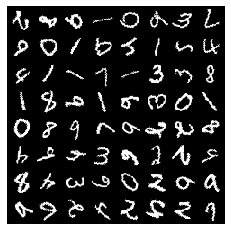

In [13]:
import math
from torchvision.datasets import MNIST
from torchvision.transforms.functional import rotate

class RotatedMNIST(MNIST):
#     def __init__(self, *args, **kwargs):
#         print(kwargs)
#         super(RotationMNIST, self).__init__(root=)
    def __getitem__(self, i):
        #a, b = 0, math.pi
        input, target = super(RotatedMNIST, self).__getitem__(i)
#         ## Method 1: y in [0,1]
#         target = torch.rand(1,dtype=torch.float32)
#         input = rotate(input, target*360)
        ## Method 2: y in [-1,1]
        target = 2*torch.rand(1,dtype=torch.float32) -1 
        input = rotate(input, target*180)        
        input = transforms.ToTensor()(input)
        return input, target#.item()       
    

transform = transforms.Compose([
    torchvision.transforms.ToTensor(),  
])

train = RotatedMNIST('~/datasets/', train=True, transform=None, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
test = RotatedMNIST('~/datasets/', train=False, transform=None, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)


X, Y = iter(train_loader).next()

show(make_grid(X[:64]))
print(Y[:10])
print(X.dtype, Y.dtype)

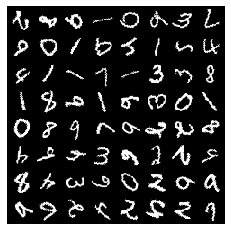

In [15]:
fig, ax = plt.subplots()

show(make_grid(X[:64]))

plt.show()

In [16]:
ax

In [18]:

sys.path.append('../cpflow')
from lib.icnn import ConvICNN, ICNN3


x = torch.randn(16, 11)
net = ICNN3(dim=11)
net(x).shape

torch.Size([16, 1])

In [28]:
from functools import partial

n = partial(ICNN3, dim=11)
print(dir(n))
callable(n)

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'args', 'func', 'keywords']


True

In [21]:
#isinstance(ICNN3, torch.nn.Module)
issubclass(ICNN3, torch.nn.Module)

True

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [54]:
import importlib
import src.flow
importlib.reload(src.flow)

from src.flow import logdet_estimate




In [52]:
import pytorch_lightning as pl
import torch.nn.functional as F



from src.icnn import FICNN

# For Y in [0,1]
def angle_loss(deg_pred, deg_true):
    """ Converts values in range [0,1] to angles in radians"""
    θ_pred = 360 * deg_pred * (math.pi/180)
    θ_true = 360 * deg_true * (math.pi/180)
    loss = 1 - torch.cos(θ_pred - θ_true)
    return loss.mean()

# For Y in [-1,1]
def angle_loss(deg_pred, deg_true):
    """ Converts values in range [-1,1] to angles in radians"""    
    θ_pred = 360 * ((1+deg_pred)/2) * (math.pi/180)
    θ_true = 360 * ((1+deg_true)/2) * (math.pi/180)
    loss = 1 - torch.cos(θ_pred - θ_true)
    return loss.mean()


class RotMNISTLitICNN(pl.LightningModule):

    def __init__(self):
        super().__init__()
        #self.net = FICNN(hidden_dims=[200,200,200,50,25])
        #self.net = ConvICNN()
        self.net = ICNN3(dim=28*28)
    
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = x.view(x.size(0), -1)        
        output = self.net(x)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        pred = self.net(x)
        #loss = F.mse_loss(pred, y)
        loss = angle_loss(pred, y)
        return loss

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         x = x.view(x.size(0), -1)
#         pred = self(x)
#         loss = F.mse_loss(y, pred)
#         result = pl.EvalResult()
#         result.log('test_loss', loss)
#         return result
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    
model = LitICNN()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type  | Params
-------------------------------
0 | net  | ICNN3 | 26 K  


Saving latest checkpoint..


1

tensor([[0.7440],
        [0.0379],
        [0.9781],
        [0.9771],
        [0.9738],
        [0.6451],
        [0.1646],
        [0.3650],
        [0.4522],
        [0.6892]]) tensor([[ -0.9627],
        [ -1.4339],
        [  1.7331],
        [ -2.0197],
        [  7.6111],
        [ -0.6045],
        [ -0.8830],
        [-14.6027],
        [  5.7516],
        [ -9.7624]], grad_fn=<ViewBackward>)


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/daalvare/.pyenv/versions/3.7.4/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/daalvare/.pyenv/versions/3.7.4/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backen

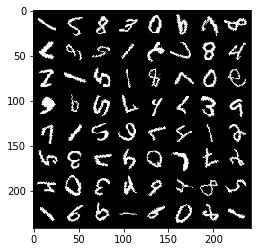

In [45]:


X, Y = iter(test_loader).next()
show(make_grid(X[:64]))
plt.show()

#show(make_grid(model(X[:64].view(64,-1))).view(64,28,28))
# print(X.shape)
print(Y[:10], model(X[:10].view(10, -1)))


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/daalvare/.pyenv/versions/3.7.4/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/daalvare/.pyenv/versions/3.7.4/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backen

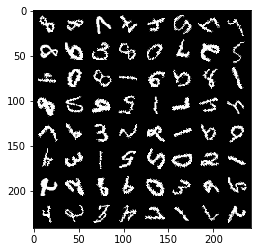

In [43]:
X_unrot = torch.stack([transforms.ToTensor()(rotate(transforms.ToPILImage()(X[i]), -model(X[i].view(1,-1))*360)) for i in range(64)])
show(make_grid(X_unrot[:64]))
plt.show()

In [3]:
# Load model if not re-trained


show(make_grid(X_unrot[:64]))



NameError: name 'X_unrot' is not defined

In [35]:

sys.path.append('../cpflow')
from lib.icnn import  ICNN3, ConvICNN, ConvICNN2


print(X.shape)

# net = ICNN3(dim=11)
# print(net(X).shape)

net = ConvICNN(dimh=100)
print(net(X).shape)


net = ConvICNN2()
print(net(X).shape)





torch.Size([128, 1, 28, 28])
torch.Size([128, 1])
torch.Size([128, 1])


In [99]:
import importlib 
import src.flow
importlib.reload(src.flow)
from src.flow import GradFlow

from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

model = model.eval()


### Define Objective Funcitonal

# Sinkhorn divergence as Functional
ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, debias=True)   #Other options: loss='energy', 'laplacian', 'gaussian' (MMD)
#F = partial(ot_loss, Y) # F(rho) = SD(rho, \beta)
#f_input_type = '∇x'


F = lambda x: model(x).mean() + ot_loss(x, X)
f_input_type = '∇x'


gf = GradFlow(X.reshape(X.size(0),-1), F=F, τ=1e3, lr = 1e-3, opt_iters=500, f_input_type=f_input_type)

#gf = GradFlow(X, F=F, Y=Y, τ=1e3, lr = 1e-3, opt_iters=500, f_input_type=f_input_type, save_path = save_path)

XT = gf.flow(steps=20)



Step: 0
It   l_W    l_F    l+     ||X||  ||T(X)||


ValueError: Input samples 'x' and 'y' should be encoded as (N,D) or (B,N,D) (batch) tensors.

In [87]:
show(make_grid(XT[:64]))


NameError: name 'XT' is not defined

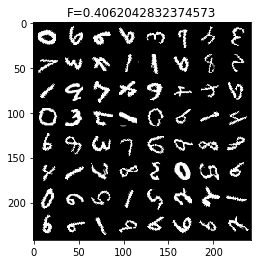

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


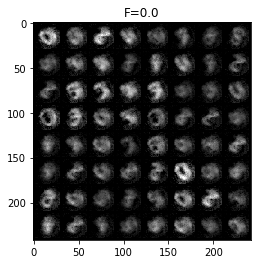

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


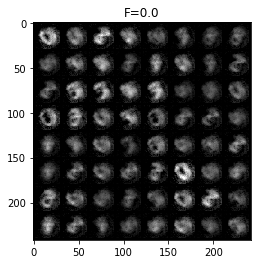

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


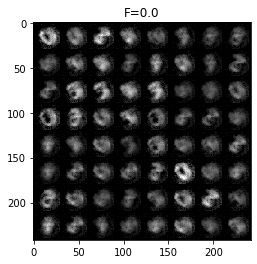

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


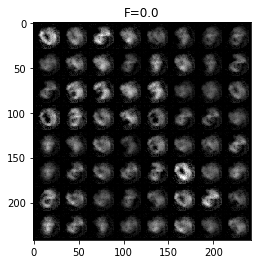

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


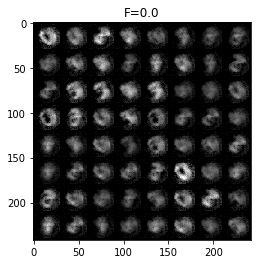

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


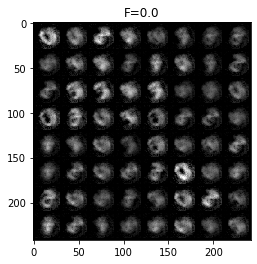

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


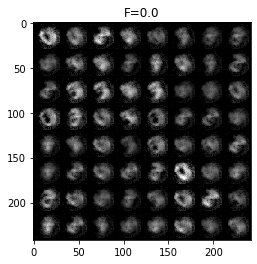

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


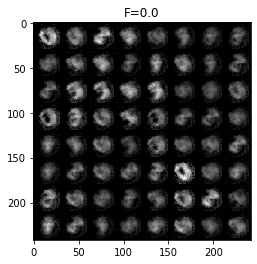

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


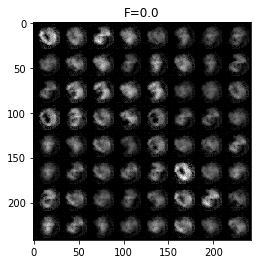

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


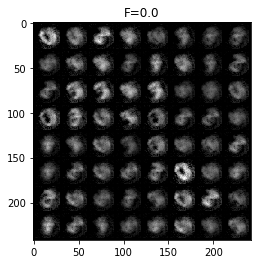

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


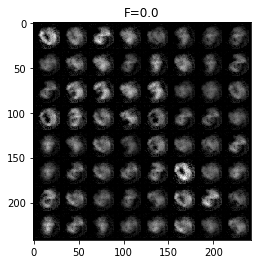

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


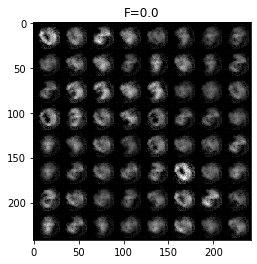

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


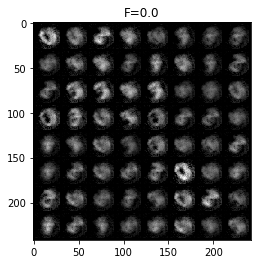

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


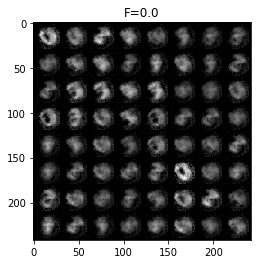

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


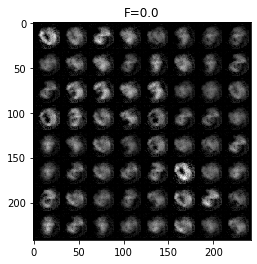

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


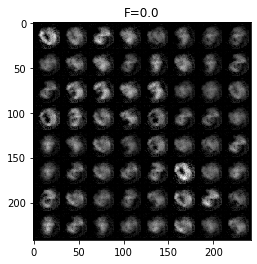

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


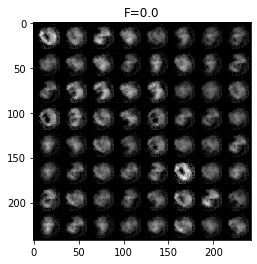

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


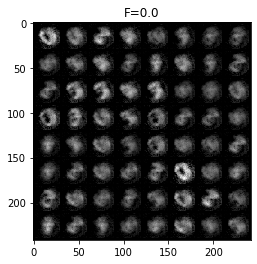

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


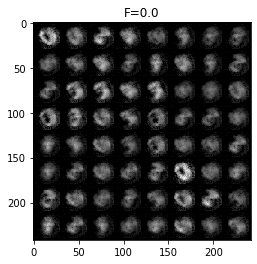

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


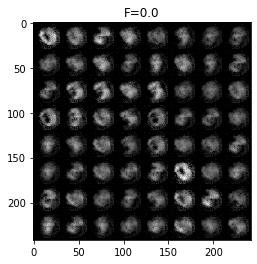

In [89]:
for i in range(gf.X_hist.shape[-1]):
    show(make_grid(gf.X_hist[:64,:,i].reshape(64,1,28,28)))
    plt.title(f'F={F(gf.X_hist[:64,:,i])}')
    plt.show()

In [97]:
X.shape

torch.Size([128, 1, 28, 28])

In [98]:
model(X).shape

torch.Size([128, 1])